# Finite Element Analysis with `PyNite`

<center><img src = 'Full Logo No Buffer.png' width=300px></center>


Having access to a structural-engineering-oriented finite element analysis tool is probably one of the first tools that every structural engineer wants in their toolkit.

`PyNite` was written, and is actively maintained, by a structural engineer named D. Craig Brinck (SE) in the United States. He is very passionate about the project and he will likely be maintaining it for a long time to come. 

As your Python skill develops, you may want to help the effort and contribute some features yourself! Open source software thrives on community contributions, especially in our structural engineering community.

<center><h1>🤝</h1></center>
    
## Some of the key `PyNite` features

* 3D frame elements
* Shell elements (MITC4 formulation)
* Plate elements (12-term polynomial formulation)
* Linear elastic analysis
* P-Δ analysis of frame structures
* Tension-only and compression-only frame elements
* Spring elements, two-way and one-way (either tens. or comp.)
* Spring supports, two-way and one-way (either tens. or comp.)
* Automatic node creation at member/member intersections
    * This facilitates easy definition of grillage models
* Automatic recognition of member/node intersections
* Handles load cases and load combinations
* Beam plots
* 3D Visualization


## Typical imports

When you installed the `pfse_starterkit`, you installed `PyNiteFEA` as one of the dependencies.

In order to use any of the Python libraries that you have installed, you need to first _import_ them.

Different libraries have different "main" pieces. In the case of `PyNiteFEA`, the two most useful components to import are `FEModel3D` object and the `render_model` function.

In [2]:
from PyNite import FEModel3D
from PyNite.Visualization import render_model

## Setting up and performing an analysis

Similar to commercial software tools, `PyNite` uses the following approach:
1. Identify and define nodes
2. Define members based on node connectivity and material properties
3. Define support behaviour for each node
    1. Nodes that do not have support behaviour are considered free and unrestrained
4. Define load cases and combinations (optional for simple loading)
5. Apply loads to members or joints
6. Run analysis

### `PyNite` sign conventions and coordinate system
<center><img src='Member Local Coordinates.png' width=400></center>

## Learn by Example: Beam Analysis

* Some of the syntax below will likely be intuitive for you but some of it might not be
* A full-and-complete explanation at this point would be very long
* Instead, as you read the code below, try and develop an intuition of what is happening
* Over the following weeks, more and more of those questions about syntax and "what is actually happening" will be answered
* For now, I am just going to do a bunch of "hand waving" explanations so you can get a feel for how to use the tool

### We will use `PyNite` to perform a beam analysis of the configuration you see here

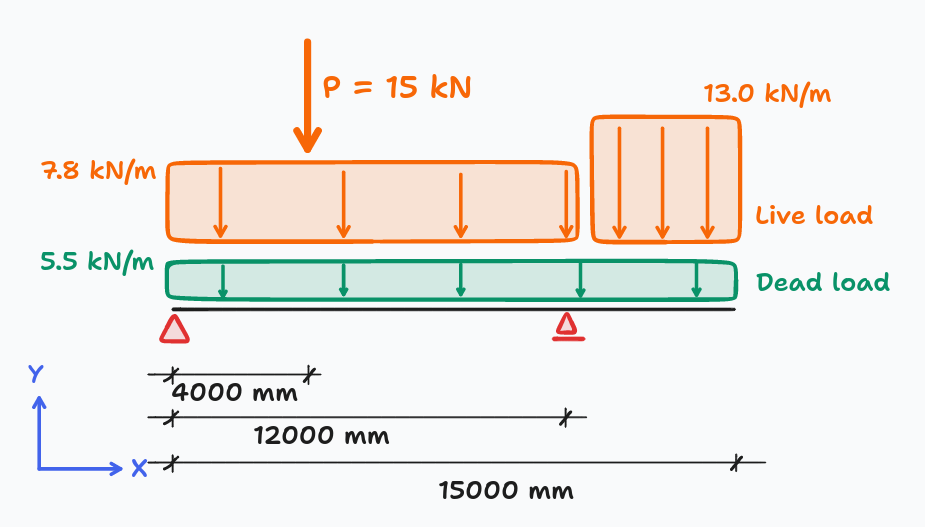

**To start, give the following code a read-through. As a structural engineer, I expect that you can get an intuitive sense of what is happening**.

Then, copy and paste the code in the empty cell below. Type `Shift-Enter` to run the cell.

```python
beam_model = FEModel3D() # Creates an empty model

E = 200e3     # Modulus of elasticity (MPa)
G = 77e3      # Shear modulus of elasticity (MPa)
nu = 0.3      # Poisson's ratio
rho = 7.7e-6  # Density (kci)
beam_model.add_material('Steel', E, G, nu, rho)

beam_model.add_node(name="node1", X=0, Y=0, Z=0) # Change the model by adding nodes
beam_model.add_node("node2", 12000, 0, 0)
beam_model.add_node("node3", 15000, 0, 0)

beam_model.add_member(name="M1", i_node="node1", j_node="node3", material="Steel", Iy=20e6, Iz=400e6, J=30e3, A=1500)

beam_model.def_support("node1", support_DX=True, support_DY=True, support_DZ=True, support_RX=True, support_RY=False, support_RZ=False)
beam_model.def_support("node2", False, True, True, False, False, False)

beam_model.add_load_combo(name="LC1", factors={"D": 1.4})
beam_model.add_load_combo("LC2", {"D": 1.25, "L": 1.5})

beam_model.add_member_dist_load(Member="M1", Direction="Fy", w1=-5.5, w2=-5.5, x1=0, x2=15000, case="D")
beam_model.add_member_dist_load("M1", "Fy", w1=-7.8, w2=-7.8, x1=0, x2=12000, case="L")
beam_model.add_member_dist_load("M1", "Fy", w1=-13.0, w2=-13.0, x1=12000, x2=15000, case="L")

beam_model.add_member_pt_load(Member="M1", Direction="Fy", P=-15000, x=4000, case="L")

beam_model.analyze(check_statics=True) # Changes the model by performing the analysis and adding analysis results

beam_model.Members['M1'].plot_shear(Direction="Fy", combo_name="LC1", n_points=100)
beam_model.Members['M1'].plot_moment(Direction="Mz", combo_name="LC1", n_points=100)

render_model(beam_model, combo_name='LC2', annotation_size=500)
```

# Breaking it down

## Creating the model
```python
beam_model = FEModel3D()
```
* The primary "object" in `PyNite` is `FEModel3D`. With this, a model is initialized and all other functionality we need comes from the model.
    * We use the "function calling" syntax of open-close parentheses to indicate that we are "calling" for a new `FEModel3D` to be created, which we will store in a variable name of our own choosing, in this case, I chose `beam_model`.
    * We would say, "`beam_model` is an 'instance' of the `FEModel3D` object"
---    

## Add a material

```python
E = 200e3     # Modulus of elasticity (MPa)
G = 77e3      # Shear modulus of elasticity (MPa)
nu = 0.3      # Poisson's ratio
rho = 7.7e-6  # Density (kci)
beam_model.add_material('Steel', E, G, nu, rho)
```
The above uses intermediate variables to define the material but you can also plug values directly into the function arguments:

```python
beam_model.add_material(name='Steel', E=200e3, G=77e3, nu=0.3, rho=7.7e-6)
```

You can also enter the arguments positionally, without using the parameter names (in this case, the order is important):

```python
beam_model.add_material('Steel', 200e3, 77e3, 0.3, 7.7e-6)
```

## Add nodes

```python
beam_model.add_node(name="node1", X=0, Y=0, Z=0) # Change the model by adding nodes
beam_model.add_node("node2", 12000, 0, 0)
beam_model.add_node("node3", 15000, 0, 0)
```
* The `beam_model` has a function built into it called `.add_node` which takes four parameters: `name`, `X`, `Y`, `Z`
* When you call the `.add_node` function, it modifies the `beam_model` in place.
---

## Add members

_Use `.add_member` to add a member between nodes. Members can span "through" multiple nodes and connectivity will be automatically created. Members can intersect other members with intersection nodes being created automatically. This is a feature that PyNite calls "physical members"._

```python
beam_model.add_member(name="M1", i_node="node1", j_node="node3", material="Steel", Iy=20e6, Iz=400e6, J=30e3, A=1500)
```
* The `beam_model` also has a function called `.add_member` which takes many arguments.
* Some of the parameters are required, like the ones shown here:
    * `name`, your own name for the member
    * `i_node`, the name of the start node
    * `j_node`, the name of the end node
    * `material`, the name of a previously defined material (the name must be an exact match)
    * `Iy`, the moment of inertia about the local y-axis (often the "weak" axis)
    * `Iz`, the moment of inertia about the local z-axis (often the "strong" axis)
    * `J`, the polar (torsional) moment of inertia
    * `A`, the area of the member section
* There are additional, _optional_, parameters you may also specify. These include:
    * `auxNode`, the name of an additional node in 3D space that you can use to define the local xz plane. This is used to rotate or orient the member in 3D space (default is `None`)
    * `tens_only`, either `True` or `False` (default is `False`) to describe whether the member is a tension only member
    * `comp_only`, either `True` or `False` (default is `False`) to describe whether the member is a compression only member
---

## Define supports

_Use `.def_support` to define supports at node locations._

```python
beam_model.def_support("node1", support_DX=True, support_DY=True, support_DZ=True, support_RX=True, support_RY=False, support_RZ=False)
beam_model.def_support("node2", False, True, True, False, False, False)
```
* Note, that we do not _add_ a support, we _define_ a support because a support is just a node and the nodes have already been added, therefore the function is called `def_support`.
* The `def_support` function takes seven parameters:
    * `node_name`, the name of the node to define as a support
    * `support_DX`, determines support behaviour of deflection in the _global_ X direction (default=`False`)
    * `support_DY`, determines support behaviour of deflection in the _global_ Y direction (default=`False`)
    * `support_DZ`, determines support behaviour of deflection in the _global_ Z direction (default=`False`)
    * `support_RX`, determines support behaviour in rotation about the _global_ X direction (default=`False`)
    * `support_DY`, determines support behaviour in rotation about the _global_ Y direction (default=`False`)
    * `support_DZ`, determines support behaviour in rotation about the _global_ Z direction (default=`False`)
---

## Load combos

_If you do not add a load combo, there is a default one that you can use for quick analysis. It is called `"Combo 1"`._
```python
beam_model.add_load_combo(name="LC1", factors={"D": 1.4})
beam_model.add_load_combo("LC2", {"D": 1.25, "L": 1.5})
```

* The function `.add_load_combo` takes two parameters:
    * `name`, the name you want to assign to the load combination
    * `factors`, a Python dictionary consisting of `"load_case": factor` pairs.
    
* Note, the function has no knowledge of any design codes so you must specify the names of your cases and combos
* Dictionaries will be covered in Lesson 1 so do not worry about the syntax or the details of how it works yet but I am hoping that you can kind of see how they work. They are a collection of items, surrounded by curly braces `{` `}`, of `keys: values` where each `key: value` pair is separated by a `,`

---

## Add member loads

_If you do not provide a load case on a load, there is a default one that is assigned for quick analysis. It is called `Case 1` and it is already a part of the `Combo 1` load case._

### Sign convention

Loads are added to frame elements ("members") in the element's _local_ coordinate system. 

The `Direction` parameter must be one of the following values:
* `"Fx"` (this is the "axial" direction relative to the element)
* `"Fy"` (this is often the "gravity" direction relative to the element)
* `"Fz"` (this is often the "lateral" direciton relative to the element)
* `"Mx"` (torsion)
* `"My"` (often "weak-axis" bending)
* `"Mz"` (often "strong-axis" bending)

> **Note**: The _distributed loads_ can only be one of `"Fx"`, `"Fy"`, or `"Fz"`. Only the point loads can be any one of the six.

### Adding distributed loads to a member
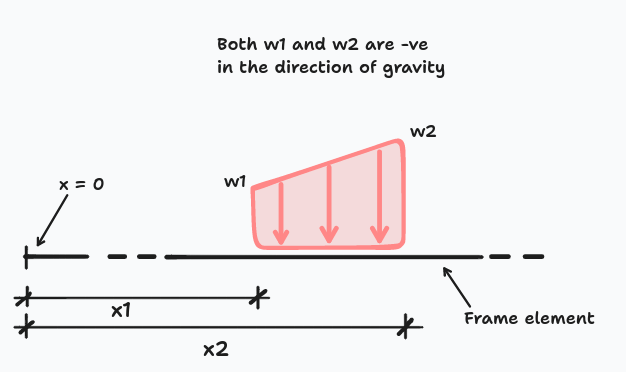

The `.add_member_dist_load` function takes seven parameters:
1. `Member`, the name of the member you assigned when you created it
2. `Direction`, one of either `"Fx"`, `"Fy"`, or `"Fz"`
3. `w1`, the start magnitude of the distributed load in units of force/distance
4. `w2`, the end magnitude of the distributed load in units of force/distance
5. `x1`, the location of `w1`
6. `x2`, the location of `w2`
7. `case`, the name of the load case that this load belongs to (if not assigned, `"Case 1"` will be auto-assigned)

```python
beam_model.add_member_dist_load(Member="M1", Direction="Fy", w1=-5.5, w2=-5.5, x1=0, x2=15000, case="D")
beam_model.add_member_dist_load("M1", "Fy", w1=-7.8, w2=-7.8, x1=0, x2=12000, case="L")

# Adding a load without specifying load case: "Case 1" will automatically be assigned
beam_model.add_member_dist_load("M1", "Fy", w1=-4.0, w2=-4.0, x1=1000, x2=10000)
```

## Add point loads to a member

_Point loads, as with distributed loads (and all loads), if you do not specify a load case, your load will be assigned the case `"Case 1"` which is a part of `"Combo 1"`_

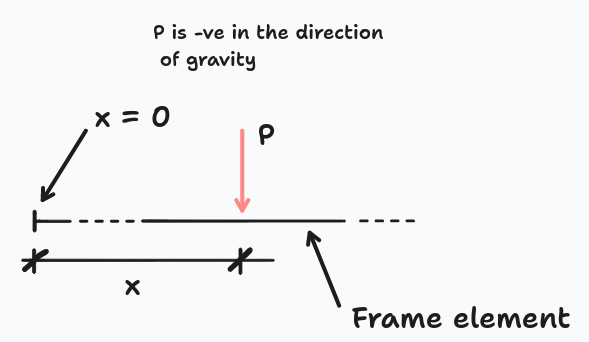

The `.add_member_pt_load` function takes five parameters:
1. `Member`, the name of the member you assigned when you created it
2. `Direction`, one of either `"Fx"`, `"Fy"`, `"Fz"`, `"Mx"`, `"My"`, `"Mz"`
3. `P`, the start magnitude of the distributed load in units of force
4. `x`, the location of `P`
5. `case`, the name of the load case that this load belongs to (if not assigned, `"Case 1"` will be auto-assigned)

```python
beam_model.add_member_pt_load(Member="M1", Direction="Fy", P=-15000, x=4000, case="L")
```

---

## Add node loads to a node

_Loads can be added to nodes in the __global__ coordinate system._

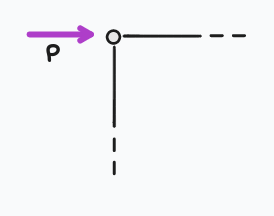

The `add_node_load` function takes four parameters:

1. `Node`, the name of the node that you assigned when you created it
2. `Direction`, one of either `"FX"`, `"FY"`, `"FZ"`, `"MX"`, `"MY"`, `"MZ"`
3. `P`, the magnitude of the load in units of force or force-distance (for moments)
4. `case`, the name of the load case that this load belongs to (if not assigned, `"Case 1"` will be auto-assigned)


```python
# Note: This node load was not used in the beam example above
beam_model.add_node_load(Node="node3", Direction="MZ", P=-15e6)
```
---

## Analyzing the model

_The `FEModel3D` object has a multiple analysis functions you can use: `.analyze`, `.analyze_linear`, and `.analyze_PDelta`. Each of these have the ability to check model stability._

### Using `.analyze()`

_`.analyze` is the most common analysis function. It iteratively solves compression-/tension-only elements and it does so by computing a global stiffness matrix for each load combination._

This analysis function takes the following optional parameters:

* `log`, When `True`, prints an analysis log to the console. Default is `False`
* `check_stability`, When `True`, displays a warning if a singular matrix is formed or if there are errors in joint connectivity. Default is `True`.
* `check_statics`, When `True`, prints a table to the console showing sum of the forces and sum of the reactions. Default is `False`.
* `max_iter`, Only invoked when there are tension-only or compression-only members. Default is `30`.
* `sparse`, When `True` a sparse matrix solver is used. Default is `True`.

### Using `.analyze_linear()`

_`.analyze_linear` is faster when there are no compression-/tension-only elements because it computes the global stiffness matrix once and then creates load combinations with super-position._

This analysis function takes the following optional parameters:

* `log`, When `True`, prints an analysis log to the console. Default is `False`
* `check_stability`, When `True`, displays a warning if a singular matrix is formed or if there are errors in joint connectivity. Default is `True`.
* `check_statics`, When `True`, prints a table to the console showing sum of the forces and sum of the reactions. Default is `False`.
* `sparse`, When `True` a sparse matrix solver is used. Default is `True`.

### Using `.analyze_PDelta()`

_`.analyze_PDelta`, as the name suggests, will iteratively perform a P-Δ analysis._

This analysis function takes the following optional parameters:

* `log`, When `True`, prints an analysis log to the console. Default is `False`
* `check_stability`, When `True`, displays a warning if a singular matrix is formed or if there are errors in joint connectivity. Default is `True`.
* `check_statics`, When `True`, prints a table to the console showing sum of the forces and sum of the reactions. Default is `False`.
* `max_iter`, Only invoked when there are tension-only or compression-only members. Default is `30`. If this number is exceeded during analysis, an error will be raised and non-convergence will be reported. Default is `30`.
* `tol`, The tolerance that should be used to define convergence. Default is `0.01` meaning that the difference between iterations will be a maximum of 1% at convergence.
* `sparse`, When `True` a sparse matrix solver is used. Default is `True`.

---

# Rendering your model using `render_model`

A wonderful feature of `PyNite` is that it uses the VTK ([Visualization Tool Kit](https://vtk.org/)) to render your model in 3D. This capability is built into the `render_model` function
that we imported at the beginning with this line:

```python
from PyNite.Visualization import render_model
```

_You can render your model at any time, for example, to confirm that your node and loading configurations are correct. Using `render_model` can be useful for troubleshooting._

The `render_model` function has the following parameters:

* `model`, This parameter is required. It is where you pass your `FEModel3D` instance (in this example, we assigned it to a variable `beam_model`)
* `annotation_size=5`, This parameter is what you should play with when your model looks funny. In particular, if your beam looks like "just a horizontal line", then increase this value. If you increase it too much then your model will look like "just a big support".
* `deformed_shape=False`, When `True` will plot the deformed shape. Default is `False`
* `deformed_scale=30`, Sets the scale of the deformed shape. Default is `30`.
* `render_loads=True`, When `True`, will display all load cases on the frame. Default is `True`.
* `color_map=None`, Applies only to membrane and shell elements. 
* `scalar_bar=True`, Applies only to membrane and shell elements.
* `combo_name='Combo 1'`, **Important**: You must select the load combination you want to have displayed. Default is `'Combo 1'`.
* `case=None`, **Important**: If you set, `combo_name = None`, then you can specify a load _case_ you would like rendered instead.
* `labels=True`, When `True`, will apply labels to _members_ and _nodes_. Default is `True`.
* `screenshot=None`, If a filename is provided, a screenshot of the 3D view will be taken when the window is closed. Default is `None`.

```python
render_model(beam_model, labels=False, combo_name="LC2", annotation_size=300)
render_model(beam_model, deformed_shape=True, combo_name="LC1", annotation_size=300)
```
---

## Display Member Forces

_In `PyNite` member results are considered to "belong" to the member in question. To access them, we first need to access the member which we want to review. This notation will be explained further in **Lesson 1** but for now just take this as another hand-wavy explanation of what to do._

To access a `Member` by name, do this:

```python
beam_model.Members['M1']
```

This can be interpreted as follows: "From the collection of members in my `FEModel3D`, retrieve the member labeled `'M1'`"

### Plot a given resultant action

A variety of functions are available on a member to plot the resultant actions:

* `beam_model.Members['M1'].plot_shear(Direction, combo_name, n_points)`, where `Direction` must be one of `"Fy"` or `"Fz"`
* `beam_model.Members['M1'].plot_moment(Direction, combo_name, n_points)`, where `Direction` must be one of `"My"` or `"Mz"`
* `beam_model.Members['M1'].plot_deflection(Direction, combo_name, n_points)`, where `Direction` must be one of `"dy"` or `"dz"`
* `beam_model.Members['M1'].plot_torque(combo_name, n_points)`
* `beam_model.Members['M1'].plot_axial(combo_name, n_points)`

While only some of the above functions require a `Direction`, they _all_ require a `combo_name` to plot and the "resolution" of the plot given by `n_points`.

* `combo_name = "Combo 1"`, default is `"Combo 1"`
* `n_points = 20`, default is `20` (probably not enough points, try 100 or 200)

```python
beam_model.Members['M1'].plot_moment('Mz', combo_name='LC2', n_points=300)
beam_model.Members['M1'].plot_deflection('dy', combo_name='LC2', n_points=300)
```
---

In [ ]:
beam_model.Nodes['node3'].DY

## Display Node Reactions

_In `PyNite` reactions are considered to "belong" to the node with the defined support. To access them, we first need to access the node which we want to review. Like for **Members** above, this notation will be explained further in **Lesson 1**._

To access a `Node` by name, do this:

```python
beam_model.Nodes['node1']
```

To access reactions, use the following _attributes_ on the node. An _attribute_ does _not require the use of open and closed parentheses `(` `)` that functions do.

```python
beam_model.Nodes['node1'].RxnFY # Note, that it is FY instead of Fy because nodes work in global coordinates
beam_model.Nodes['node2'].RxnFY
```

These reactions are given to us in a _dictionary_ that contains the reactions for all load combinations. To see them, it is best to use the built-in Python `print` function.

```python
print(beam_model.Nodes['node1'].RxnFY)
print(beam_model.Nodes['node2'].RxnFY)
```

The available reaction attributes are as follows:

* `.RxnFX`
* `.RxnFY`
* `.RxnFZ`
* `.RxnMX`
* `.RxnMY`
* `.RxnMZ`

Additionally, for free nodes (without support definitions), _deflections_ can be obtained in a similar way:

* `.DX`
* `.DY`
* `.DZ`

Like this: 

```python
print(beam_model.Nodes['node3'].DY)
```